#  Demand Forecasting. Part 1. Sklearn library

В этом занятии знакомимся с библиотекой <a href='https://scikit-learn.org/stable/getting_started.html'> Scikit Learn </a>, или SKLearn. 

Это опенсорсная библиотека по машинному обучению. Библиотека содержит разнообразные инструменты для:
- обучения моделей как с учителем, так и без учителям
- подготовки данных
- отбора моделей
- оценки моделей
- и многого другого 

Как правило, импортируется не вся библиотека разом, а отдельные модули или даже отдельные функции.
Поэтому дополнять код инструментами будем в процессе, а не сразу в одной ячейке!

## Данные
Для демонстрации работы библиотеки используем датасет про [Walmart](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting). Есть информация о 45 магазинах, расположенных в разных регионах. Каждый магазан содержит несколько отделов. Наша задача спрогнозировать продажи по каждому отделу для каждого магазина. 


* `Weekly_Sales` - объём продаж в данную неделю в данном отделе (целевая переменная)
* `Store` - номер магазина;
* `Type` - тип магазина;
* `Size` - размер магазина;
* `Dept` - номер отдела;
* `Date` - дата;
* `IsHoliday` - является ли неделя праздничной;

В Walmart работает несколько акций по уценке товаров. Эти уценки обычно связаны с праздниками: Суперкубок, день Труда, день Благодарения, Рождество. С этими периодами нужно быть аккуратным. Продажи в эти дни аномальны, при этом наблюдений, связанных с этими аномалиями довольно мало.

Для удобства вот информация о всех праздниках, попавших в датасет: 

```
Суперкубок: 12-Фев-10, 11-Фев-11, 10-Фев-12
День Труда: 10-Сен-10, 9-Фев-11, 7-Сен-12
День Благодарения: 26-Ноя-10, 25-Ноя-11, 23-Ноя-12
Рождество: 31-Дек-10, 30-Дек-11, 28-Дек-12
```

* `Temperature` - средняя температура в регионе в градусах по Фаренгейту;
* `Fuel_Price` - стоимость топлива в регионе;
* `MarkDown1-5` - данные, связанные с рекламными уценками, которые запускает Walmart. Данные уценки доступны только после ноября 2011 года и доступны не для всех магазинов. Данные анонимизированы. Непонятно на какие именно товары производилась уценка и в каких количествах. Компании часто анонимизируют данные, когда выкладывают их в опен сорс.  
* `CPI` - индекс потребительских цен.
* `Unemployment` - уровень безработицы.

### Загрузка данных

In [137]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [85]:
df = pd.read_csv('walmart.csv', sep='\t')
df.head()

,Store,Date,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,2010-02-05,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2010-02-05,2,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,2010-02-05,3,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,2010-02-05,4,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,2010-02-05,5,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Date          421570 non-null  object 
 2   Dept          421570 non-null  int64  
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


## Предобработка данных без Sklearn

В данных точно есть пропуски!

In [87]:
df.fillna(0, inplace=True)  # опция inplace применяет изменения к df

In [88]:
# организуем правильную запись категориальных переменных
df['Store'] = df['Store'].astype('str')  # каждое число - категория, сообщим питону об этом
df['Dept'] = df['Dept'].astype('str')    # каждое число - категория, сообщим питону об этом

In [89]:
# переводим температуру в Цельсии
df['Temperature'] = (df['Temperature'] - 32) * 5/9

In [90]:
# Работа со временем расписана тут: https://pythonworld.ru/moduli/modul-datetime.html
# делаем у колонки дата временной тип
# df['DateType'] = pd.to_datetime(df['Date'])
df['DateType'] = df['Date'].apply(lambda w: datetime.strptime(w, '%Y-%m-%d')) 

# df['Month'] = df['DateType'].dt.month
# вводим отдельную переменную для месяца, когда происходили продажи 
df['Month'] = df['DateType'].apply(lambda w: 'Month_' + str(w.month))

# Работаем с особыми днями! 
# Чёрная пятница
df['Black_Friday'] = np.where((df['DateType']==datetime(2010, 11, 26).date()) | \
                              (df['DateType']==datetime(2011, 11, 25).date()) | \
                              (df['DateType']==datetime(2012, 11, 23).date()), 1, 0)

# Предрождественские деньки: 
df['Pre_christmas'] = np.where((df['DateType']==datetime(2010, 12, 23).date()) | \
                               (df['DateType']==datetime(2010, 12, 24).date()) | \
                               (df['DateType']==datetime(2011, 12, 23).date()) | \
                               (df['DateType']==datetime(2011, 12, 24).date()) | \
                               (df['DateType']==datetime(2012, 12, 23).date()) | \
                               (df['DateType']==datetime(2012, 12, 24).date()), 1, 0)


Для удобства, создадим два списка из переменных. В первый войдут все действительные, во второй все категориальные. Переменная `Weekly_Sales` не войдёт ни в один из списов. Мы же её прогнозируем! Переменная `Date` также не войдёт ни в один из списков. Она техническая и нужна для удобства. Мы на её основе сделаем несколько новых переменных немного позже. 

In [91]:
# Date - техническая переменная, 
# Weekly_Sales - таргет

# категориальные переменные 
var_cat = ['Type', 'Store', 'Dept', 'IsHoliday']

# непрерывные переменные
var_real = ['MarkDown1','MarkDown2', 'MarkDown3',
            'MarkDown4','MarkDown5', 'CPI', 'Unemployment', 
            'Temperature', 'Fuel_Price','Size']

In [92]:
# посмотрим на основные порядковые статистики, связанные с нашей выборкой
df.describe()

,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Black_Friday,Pre_christmas
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.0,421570.0
mean,15981.258123,136727.915739,15.605588,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,0.0,0.0
std,22711.183519,60980.583328,10.248851,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,0.0,0.0
min,-4988.940000,34875.000000,-18.922222,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,0.0,0.0
25%,2079.650000,93638.000000,8.155556,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,0.0,0.0
50%,7612.030000,140167.000000,16.716667,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,0.0,0.0
75%,20205.852500,202505.000000,23.488889,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,0.0,0.0
max,693099.360000,219622.000000,37.855556,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,0.0,0.0


Заметили аномалии? Нет? Присмотритесь к колонке `Weekly_Sales`. Минимальное значение отрицательное. Как думаете, что это значит? Давайте оценим масштаб бедствия. 

In [93]:
sum(df['Weekly_Sales'] < 0) / df.shape[0]

0.0030481296107408022

Таких точек совсем мало. Что же означают отрицательные продажи? Один из способов проинтерпретировать это: нам вернули назад товаров больше, чем мы смогли продать. В маленьких магазинах такое вполне могло произойти. Другая интерпретация: ошибка при создании датасета. Как поступать с такими наблюдениями непонятно. Давайте пока что оставим их. 

In [94]:
df['future_sales'] = df['Weekly_Sales'].shift(-1)

## Ohe-hot-encoding

Это процедура цифровизации категориальных переменных. 
<img src='https://avatars.mds.yandex.net/i?id=b43949b06de1e89b83675e7462583a63_l-5297106-images-thumbs&n=13'>

В нашем датасете их 4: ['Type', 'Store', 'Dept', 'IsHoliday'].
Безусловно, OHE можно сделать функцией из sklearn. Однако и в пандас есть удобный функционал!

In [95]:
df.drop('DateType', axis=1, inplace=True)
print('Размерность таблицы до OHE:', df.shape)
df = pd.get_dummies(df, drop_first=True)
print('Размерность таблицы после OHE:', df.shape)
df.head()

Размерность таблицы до OHE: (421570, 20)
Размерность таблицы после OHE: (421570, 294)


,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Month_Month_11,Month_Month_12,Month_Month_2,Month_Month_3,Month_Month_4,Month_Month_5,Month_Month_6,Month_Month_7,Month_Month_8,Month_Month_9
0,24924.50,False,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,50605.27,False,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,13740.12,False,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,39954.04,False,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,32229.38,False,151315,5.727778,2.572,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


## Модуль sklearn.model_selection

В модуле собраны инструменты для разбиения данных, валидации моделей и поиска гиперпараметров моделей.

Зачем нужно совершать такие манипуляции с данными?
Все просто - мы стремимся натренировать такие модели, чтобы у них была высокая обобщающая способность.

Как в реальности используется модель прогноза спроса?
- Натренированная модель выдает прогнозы: например, в магазине Х за следующие 7 дней продадут 500 кг огурцов.
- Прогноз используют для фактического заказа товаров.
- В магазине появляется 500кг огурцов.

В идеальной картине мира хочется, чтобы и правда продались все 500кг огурцов. Но это может быть не так. Могут быть раскуплены 498кг, а могут быть 100кг.

Чтобы модель научилась давать адекватные прогнозы, во время обучения (=тренировки) симулируют и реальную работу с данными - откладывают блоки данных, на "свежих" данных проверяют качество модели

**Основные инструменты модуля**:

- **sklearn.model_selection.train_test_split**(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None

Разбивает данные на 2 части: обучающую (тренировочную) выборку, на которой тренируем модель, и контрольную (тестовую) выборку, на которой проверяем.

- **sklearn.model_selection.KFold**(n_splits=5, *, shuffle=False, random_state=None)

Класс, в котором можно организовать K-Fold-кросс-валидацию

<img src='https://miro.medium.com/v2/resize:fit:1200/1*9NosjiPCNNAhHfEdNYFfUQ.png'>

- **sklearn.model_selection.GridSearchCV**(estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)

Класс, организующий поиск по решетке - для поиска наилучших гиперпараметров

<img src='https://media.slid.es/uploads/555484/images/8438871/pasted-from-clipboard.png'> 

In [96]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [97]:
df['IsHoliday'] = df['IsHoliday']*1


In [113]:
df = df[~df['future_sales'].isna()]

In [114]:
y = df['future_sales']
X = df.drop(['future_sales', 'Weekly_Sales'], axis=1)

# делим в пропорции 70 к 30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) 

## Модуль sklearn.preprocessing

Все инструменты для обработки данных находятся здесь, в том числе:
- **sklearn.preprocessing.OneHotEncoder**(*, categories='auto', drop=None, sparse='deprecated', sparse_output=True, dtype=<class 'numpy.float64'>, handle_unknown='error', min_frequency=None, max_categories=None, feature_name_combiner='concat')

Тот самый OHE-кодировщик!

- **sklearn.preprocessing.StandardScaler**(*, copy=True, with_mean=True, with_std=True)

Стандартный шкалировщик, которые преобразует исходные данные Х по формуле:
$$ Z = \frac{(X - \mu)}{\sigma}$$

- **sklearn.preprocessing.binarize**(X, *, threshold=0.0, copy=True)

Функция, возвращающая бинарную колонку из исходной при использовании границы.

In [115]:
from sklearn.preprocessing import StandardScaler  # класс для скалирования

# объявили скалировщик!
scaler = StandardScaler()

# учим скалировщик скалировать все переменны на трэйне
scaler.fit(X_train[var_real]) 

StandardScaler()

In [116]:
# Применяем скалировщик к трэйну
X_train_scale = scaler.transform(X_train[var_real])

# Применяем скалирвощик к тесту 
X_test_scale = scaler.transform(X_test[var_real])

In [117]:
# Заменяем значения на проскалированные 
X_train[var_real] = X_train_scale
X_test[var_real] = X_test_scale

## Модуль sklearn.metrics

В модуле SKlearn находятся основные метрики для оценки качества моделей машинного обучения:
- метрики регрессии
- метрики классификации
- метрики кластеризации
- метрики ранжирования
- попарные метрики

Т.к. мы решаем задачу регрессии (прогнозируем число), остановимся на основные метриках регрессии

- **sklearn.metrics.mean_absolute_error**(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')

Первой метрикой, с которой мы познакомимся, будет **MAE (mean absolute error)**, средняя абсолютная ошибка. Она вычисляется следующим образом: 

$$ MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|. $$

Если мы спрогнозировали, что нужно 20кг огурцов, а на самом деле 10, мы ошиблись на |10 - 20| = 10 кг. Средняя абсолютная ошибка - это среднее кол-во кг, на которые мы ошиблись. 

- **sklearn.metrics.mean_squared_error**(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)

Второй метрикой является **MSE (mean squared error)**, средняя квадратичная ошибка. Она вычисляется как 

$$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2.$$

Смысл этой ошибки в том, чтобы штрафовать за большие ошибки сильнее, чем за маленькие. Если мы ошиблись на 5 кг, то в ошибку войдёт 25. Если мы ошиблись на 10 кг, то в ошибку войдёт 100. Чем выше ошибка, тем сильнее штраф. 

- **sklearn.metrics.mean_absolute_percentage_error**(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')

Часто для нас принципиальным является не то, на сколько мы ошиблись, а то на сколько процентов мы ошиблись. Метрика, которая отлавливает процентную ошибку, называется **MAPE (mean absolute percentage error)**, средняя абсолютная процентная ошибка. 

$$
MAPE = \frac{1}{n} \sum_{i=1}^n \frac{|y_i - \hat{y}_i|}{y_i}
$$

Она часто применяется в следующих задачах: например, вы прогнозируете спрос, и вам принципиально, на сколько процентов вы ошиблись, а не абсолютное значение. Если вы предсказали  один, а в реальности было  десять - это не то же самое, что вы предсказали  тысяча, а в реальности было  тысяча  девять. С точки зрения МАЕ или MSE, это две совершенно одинаковые ошибки. А если вас интересует, сколько в среднем на сколько процентов вы ошибаетесь, то это отражает МАРЕ.

- **sklearn.metrics.r2_score**(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)

Качество построенной регрессии измеряется коэффициентом детерминации
$R^2$. Он отражает то, какую долю дисперсии объясняемой переменной мы объяснили с помощью нашей модели:

$$ R^2 =1- \frac{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{ \frac{1}{n}\sum_{i=1}^{n} (y_i - \bar{y}_i)^2} $$


In [144]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [145]:
# функция, которая считает метрики и выводит их на экран
def print_metrics(y_test,y_pred):
    print('MAE:', mae(y_test, y_pred))
    print('RMSE:', np.sqrt(mse(y_test, y_pred)))
    print('R2', r2_score(y_test, y_pred))

    pass

## Наивный прогноз

In [146]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им продажи
y_pred_naive[:5]

array([15943.38854794, 15943.38854794, 15943.38854794, 15943.38854794,
       15943.38854794])

In [135]:
# та самая функция, которую мы сделали в самом начале тетрадки
print_metrics(y_test, y_pred_naive)

MAE: 15216.568371501044
MAPE 9651579083742458.0
RMSE: 23024.934056860013
R2 -3.0023812673585226e-05


## Модуль sklearn.linear_model

Здесь собраны все линейные модели:

- **sklearn.linear_model.LinearRegression**(*, fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
- **sklearn.linear_model.LogisticRegression**(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
- **sklearn.linear_model.Ridge**(alpha=1.0, *, fit_intercept=True, copy_X=True, max_iter=None, tol=0.0001, solver='auto', positive=False, random_state=None)
- ....

### Линейная регрессия

Пришло время построить линейную регрессию! Эта модель говорит, что объём продаж формируется в результате суммирования тех характеристик, которыми обладает магазин с какими-то весами

$$\hat{y} = \beta_0 + \beta_1 x_1 + ... \beta_n x_n.$$

Например, если мы оценили модель и у нас получилось, что 

$$ sales = 10000 + 20 \cdot t,$$

то это означает, что средний объём продаж равен 10 тыс. рублей. При этом каждый дополнительный градус температуры на улице в среднем при прочих равных увеличивает объёмы продаж на 20 рублей. 

Для того, чтобы подобрать коэффициенты обычно минимизируют MSE.

In [120]:
X_train

,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Month_Month_11,Month_Month_12,Month_Month_2,Month_Month_3,Month_Month_4,Month_Month_5,Month_Month_6,Month_Month_7,Month_Month_8,Month_Month_9
21732,0,-1.627930,1.271019,-1.580738,-0.428579,-0.173792,-0.084620,-0.277696,-0.397015,1.111725,...,0,0,0,0,0,0,1,0,0,0
148,0,0.240312,-1.093213,-1.849345,-0.428579,-0.173792,-0.084620,-0.277696,-0.397015,1.022449,...,0,0,1,0,0,0,0,0,0,0
136907,0,1.053432,0.820844,0.316983,0.330468,-0.131887,-0.084620,-0.199311,0.243779,0.506967,...,0,0,0,0,0,0,1,0,0,0
405978,0,-1.586637,1.203222,-1.231330,-0.428579,-0.173792,-0.084620,-0.277696,-0.397015,-1.151848,...,0,0,0,0,0,0,0,1,0,0
339260,0,-0.540846,1.023152,0.354108,0.154754,-0.173792,-0.084593,0.172094,-0.055822,-0.740113,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203609,0,0.057494,0.291482,0.024354,-0.428579,-0.173792,-0.084620,-0.277696,-0.397015,1.176559,...,0,0,0,0,0,0,0,0,0,0
120191,0,1.360490,0.159684,-1.135243,-0.428579,-0.173792,-0.084620,-0.277696,-0.397015,-1.147998,...,0,0,0,0,0,0,0,0,0,0
87143,0,-0.177572,0.730267,0.777765,0.009512,-0.173792,-0.082666,-0.178595,0.623067,1.407150,...,0,0,0,0,0,0,0,0,0,1
107099,0,1.161683,1.416919,0.290778,2.360700,-0.148348,-0.083031,0.946987,0.580649,1.384599,...,0,0,0,0,0,0,0,0,1,0


In [121]:
X_train.dtypes

IsHoliday          int64
Size             float64
Temperature      float64
Fuel_Price       float64
MarkDown1        float64
                  ...   
Month_Month_5      uint8
Month_Month_6      uint8
Month_Month_7      uint8
Month_Month_8      uint8
Month_Month_9      uint8
Length: 292, dtype: object

In [122]:
y_test.isnull().sum()

0

In [123]:
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

In [133]:
print_metrics(y_test, y_pred_regr)

MAE: 8410.734822133138
MAPE 6771797727053749.0
RMSE: 14223.183201432843
R2 0.6183986900571377


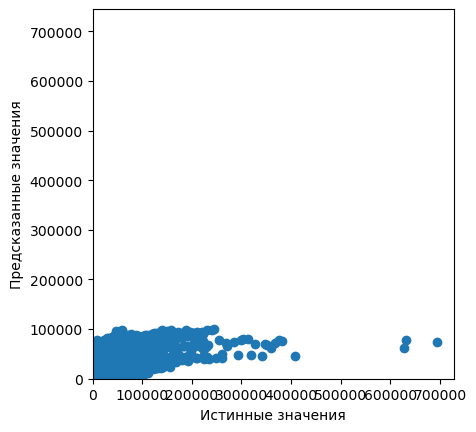

In [140]:
plt.scatter(y_test, y_pred_regr)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [29]:
%%time
from sklearn.model_selection import GridSearchCV

# Решётака для перебора параметра 
param_grid = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

# Объявили модель 
model_lasso = Lasso() 

# Объявили перебор, cv=5 это количество фолдов для валидации
grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5, scoring='neg_mean_absolute_error')

# обучаем решётку
grid_cv_lasso.fit(X_train, y_train)

CPU times: user 6min 46s, sys: 16.7 s, total: 7min 3s
Wall time: 3min 48s


Перебор работает очень долго. Для каждого `alpha` нам надо учить `cv` моделей. Всего получается в нашей ситуции учится $9 \cdot 5 = 45$ моделей. Параметров для перебора в моделях бывает много. Обычно поиск по решётке используют в случае $1,2$, ну максимум $3$ параметров.

In [ ]:
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)
print('Лучшее качество:', grid_cv_lasso.best_score_)

In [ ]:
-1*grid_cv_lasso.best_score_

In [ ]:
model_lasso = grid_cv_lasso.best_estimator_

# Сделали прогнозы
y_pred_lasso = model_lasso.predict(X_test)

In [ ]:
mae(y_test, y_pred_lasso)

Лучшее `alpha` оказалось очень маленьким. Значит модели не нужна регуляризация. Это хорошая новость.

## Модуль sklearn.tree

In [148]:
%%time
from sklearn.tree import DecisionTreeRegressor

# Объявили лес из 10 деревьев 
dt = DecisionTreeRegressor()
# Обучили лес 
dt.fit(X_train, y_train)

# Сделали по лесу прогнозы 
y_pred_tree = rf.predict(X_test)

CPU times: user 16 s, sys: 395 ms, total: 16.4 s
Wall time: 16.5 s


In [150]:
print_metrics(y_test, y_pred_tree)

MAE: 2155.394095879688
RMSE: 5778.03307954065
R2 0.9370238224814288


## Модуль sklearn.ensemble

In [141]:
%%time
from sklearn.ensemble import RandomForestRegressor

# Объявили лес из 10 деревьев 
rf = RandomForestRegressor(n_estimators=10)
# Обучили лес 
rf.fit(X_train, y_train)

# Сделали по лесу прогнозы 
y_pred_forest = rf.predict(X_test)

CPU times: user 1min 47s, sys: 872 ms, total: 1min 47s
Wall time: 1min 48s


In [149]:
print_metrics(y_test, y_pred_forest)

MAE: 2155.394095879688
RMSE: 5778.03307954065
R2 0.9370238224814288
